In [3]:
# save 2 files 1 for training the other for testing
# plot each activity count
# boxplot the activities, one plot for gyro one plot for accel

In [1]:
import numpy as np
import pandas as pd
#pd.options.display.float_format = '{:.6f}'.format

import os
from time import time
import pickle
from scipy.stats import stats # for moments
from collections import defaultdict
from scipy.fftpack import rfft # only interested in real-value results
import seaborn as sns
import matplotlib.pyplot as plt

!matplotlib inline

/bin/sh: 1: matplotlib: not found


In [4]:
!pip install pyarrow

     |████████████████████████████████| 64.2MB 6.9MB/s eta 0:00:01     |███████                         | 14.2MB 6.9MB/s eta 0:00:08  | 22.3MB 6.9MB/s eta 0:00:07��█████▊                    | 23.6MB 6.9MB/s eta 0:00:06��██████████████████████████▎ | 60.8MB 7.0MB/s eta 0:00:01


In [5]:
df = pd.read_parquet('classifyactivities.parquet', engine='pyarrow')

In [45]:
df.z= df.z.astype(float)#previously noted z was object, changed it to float
#df.timestamp= df.timestamp.astype(int)
#df['timestamp']=pd.to_datetime(df['timestamp'],unit='mcs')

df.head()

,subjectid,activity,timestamp,x,y,z,type,device
0,1639,A,184964141163193,8.288427,-4.857087,9.167398,phone,accel
1,1639,A,184964190663193,14.506168,-13.624654,14.149732,phone,accel
2,1639,A,184964240163193,8.800786,-3.229030,4.376601,phone,accel
3,1639,A,184964289663193,18.195633,-11.740417,0.481235,phone,accel
4,1639,A,184964339163193,16.316185,-3.992780,-0.986411,phone,accel


In [9]:
#format since data was displaying scientific notation
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,subjectid,timestamp,x,y,z
count,15630426.000000,15630426.000000,15630426.000000,15630426.000000,15630426.000000
mean,1626.266503,590447296652959.750000,0.129160,-1.607849,0.557048
std,14.788170,603445698477162.875000,4.792884,5.025267,3.970900
min,1600.000000,268102711042.000000,-78.477610,-78.477610,-78.477610
25%,1614.000000,107914533221983.000000,-1.423934,-4.157089,-0.640274
50%,1627.000000,370481792926658.000000,-0.001968,-0.129028,0.004527
75%,1639.000000,940768274718381.500000,1.293311,0.121321,1.786685
max,1650.000000,2724599224330653.000000,78.477610,64.411660,69.081950


In [11]:
#check if there is missing data
df.isnull().sum()

subjectid    0
activity     0
timestamp    0
x            0
y            0
z            0
type         0
device       0
dtype: int64

walking = A,jogging = B,stairs = C,sitting = D,standing = E,typing = F,teeth = G,soup = H,chips = I,pasta = J,drinking = K,
sandwich = L,kicking = M,catch = O,dribbling = P,writing = Q,clapping = R,folding = S

x,y,z units are
m/s2
, while for the gyroscope sensor, the units are
radians/s. Note that the force of gravity on Earth,
which affects the accelerometer readings, is 9.8m/s2



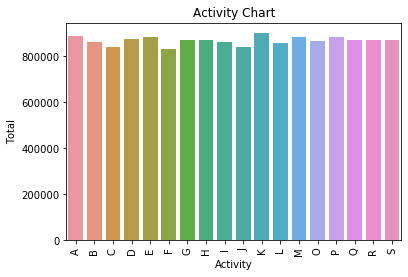

In [12]:
sns.countplot(x='activity', data=df)
plt.title('Activity Chart')
plt.ylabel('Total')
plt.xlabel('Activity')
plt.xticks(rotation = 90)
plt.show();

### shows accelerometer data from the watch for a single subject, performing the walking activity for 3 minutes

In [80]:
#lets show only  walking = A with the accelerometer for 1 subject, each activiy was done in approximatly 3 minutes, since the sampling rate is 20HZ which means 20s per reading we take the first minute to try and have less data
ax = \
accel_walking = df.query('activity == "A" & device == "accel" & subjectid==1600 & type=="watch" ')

#accel_walking = df.query('device == "accel" & subjectid==1600 & type=="phone" ')
#1 minute = 60 seconds, 20hz*1minute=20*60=1200
#accel_walking[['x','y','z']][:1200].plot(title = "Subject 1600 Accel Walking",
#                                        figsize=(25,10));
#plt.ylabel('Accel')
#plt.xlabel('Time')
#plt.show();
accel_walking[['x','y','z']].tail(50)


,x,y,z
9075099,9.830592,-0.328305,2.001702
9075100,7.647080,-0.395343,1.233164
9075101,7.410054,0.270246,1.137396
9075102,7.240066,0.152930,0.725593
9075103,7.874529,0.301370,1.005714
9075104,8.975862,-0.117615,0.823755
9075105,11.008539,-0.366612,1.395969
9075106,9.600749,-0.373795,3.268235
9075107,12.768278,0.682048,4.175637
9075108,13.460202,1.448193,4.149301


In [ ]:
#lets show only  walking = A with the accelerometer

ax = \
gyro_walking = df.query('activity == "A" & device == "gyro" & subjectid==1600')

gyro_walking[['x','y','z']].plot(title = "Subject 1600 Gyro Walking",
                                        figsize=(15,5));

plt.ylabel('Gyro')
plt.xlabel('Time')
plt.show();

#ax.set_xlabel("Time (seconds)")
#ax.set_ylabel("Acceleration");


In [20]:
accel_walking.shape

(7179, 8)

In [ ]:
from pyspark.ml.feature import StringIndexer
#transform data, integer representation
indexer = StringIndexer(inputCol="type",outputCol="typeindex")
indexed = indexer.fit(df).transform(df)
indexed.show()

In [16]:
df.device.value_counts()

accel    8581449
gyro     7048977
Name: device, dtype: int64

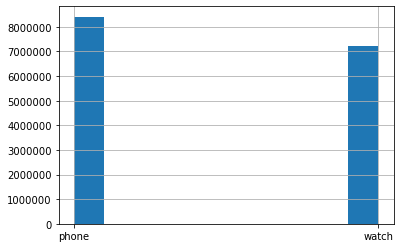

In [18]:
df.type.hist()

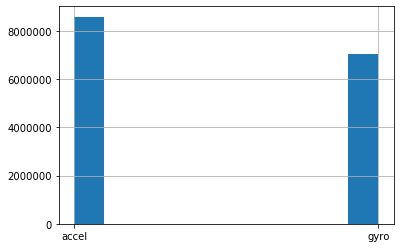

In [19]:
df.device.hist()

In [22]:
df.columns

Index(['subjectid', 'activity', 'timestamp', 'x', 'y', 'z', 'type', 'device'], dtype='object')

In [ ]:
from pandas.plotting import scatter_matrix
columns = ['x','y','z']
scatter_matrix(df[columns],    figsize  = [7, 7])
pyplot.show()

NameError: name 'pyplot' is not defined